In [4]:
from augmented_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'On {device}')
Tensor  = torch.cuda.FloatTensor
from augmented_modules import ResnetBlock, CondInstanceNorm, TwoInputSequential, CINResnetBlock, InstanceNorm2d


On cuda:0


In [2]:
tr = CyDataset()
train, val = train_test_split(tr, test_size=0.2, random_state=42)
train_dataloader = DataLoader(
    train,
    batch_size=5, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

In [8]:
prior_z_B = img.data.new(img.size(0), 16, 1, 1).normal_(0, 1)


In [9]:
mod = CINResnetGenerator(nlatent=16, input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer_C,
                 use_dropout=False, n_blocks=3, gpu_ids=[], padding_type='reflect')
img = torch.rand((5, 3, 224, 224))
x = mod(img,prior_z_B)


In [10]:
class Pixel_Level_Augmented_CycleGAN():
    def __init__(self):
        super(Pixel_Level_Augmented_CycleGAN,self).__init__()
        
        norm_layer_C = CondInstanceNorm
        norm_layer_D = functools.partial(nn.InstanceNorm2d, affine=False)
        
        self.G_ST = CINResnetGenerator(nlatent=16, input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer_C,
                 use_dropout=False, n_blocks=3, gpu_ids=[], padding_type='reflect')
        
        self.G_TS = CINResnetGenerator(nlatent=16, input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer_C,
                 use_dropout=False, n_blocks=3, gpu_ids=[], padding_type='reflect')

        self.D_T = 
        self.D_S =

        

        self.G_ST.to(device)
        self.G_TS.to(device)
        self.D_S.to(device)
        self.D_T.to(device)


        self.ganloss = GANLoss(gan_mode=self.gan_mode).to(device)       
        self.cycleloss = torch.nn.L1Loss().to(device)               #difference between reconstructed img and original
        self.mseloss = torch.nn.MSELoss().to(device)       #difference between domain classifications between input img and generator output
        self.identityloss = torch.nn.L1Loss().to(device)
        
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.G_ST.parameters(), self.G_TS.parameters()), lr=2e-5, betas=(0.5,0.999))
        self.optimizer_DS = torch.optim.Adam(self.D_S.parameters(), lr = 1e-5, betas = (0.5,0.9))
        self.optimizer_DT = torch.optim.Adam(self.D_T.parameters(), lr = 1e-5, betas = (0.5,0.9))
        self.optimizer_f_s = torch.optim.Adam(self.f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))    


        self.G_ST.apply(weights_init_normal)
        self.G_TS.apply(weights_init_normal)
        self.D_S.apply(weights_init_normal)
        self.D_T.apply(weights_init_normal)

        print('initialized')
        
    def data_input(self, batch):
        self.real_S = batch['D img'].type(Tensor)
        self.real_T = batch['L img'].type(Tensor)
        self.real_lbl = batch['D pm'].type(Tensor).float()
        self.prior = self.real_S.data.new(self.real_S.size(0), 16, 1, 1).normal_(0, 1)
        
    def sample_images(self, dataloader, epochs, iters, save = False):
        source = next(iter(dataloader))
        self.G_ST.eval()
        self.G_TS.eval()
        real_source = source['D img'].type(Tensor) 
        fake_target = self.G_ST(real_source).detach()
        real_target = source['L img'].type(Tensor)
        real_lbl= source['D pm'].type(Tensor).float()
        fake_source = self.G_TS(real_target).detach()

        recons = self.G_TS(fake_target).detach()
        recont = self.G_ST(fake_source).detach() 

        real_S = make_grid(real_source, nrow=5, normalize=True, scale_each=True, padding=1)
        fake_T = make_grid(fake_target, nrow=5, normalize=True, scale_each=True, padding=1)
        reconS = make_grid(recons, nrow=5, normalize=True, scale_each=True, padding=1)
        real_T = make_grid(real_target, nrow=5, normalize=True, scale_each=True, padding=1)
        fake_S = make_grid(fake_source, nrow=5, normalize=True, scale_each=True, padding=1)
        reconT = make_grid(recont, nrow=5, normalize=True, scale_each=True, padding=1)
        # Arange images along y-axis    
        image_grid = torch.cat((real_S, fake_T, reconS, real_T, fake_S, reconT), 2)
        plt.imshow(image_grid.cpu().permute(1,2,0))
        plt.title('Real Source vs Fake Target vs Recon Source | Real Target vs Fake Source vs Recon Target')
        plt.axis('off')
        plt.gcf().set_size_inches(10, 6)
        if save:
            plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
        plt.show();
        
    def forward_pass(self):
        self.fake_t = self.G_ST(self.real_S)
        self.fake_s = self.G_TS(self.real_T)             
        
        self.recov_s = self.G_TS(self.fake_t)
        self.recov_t = self.G_ST(self.fake_s)
        
    def backward_D(self, netD, real, fake):
         
        # Real
        pred_real = netD(real)
        if self.gan_mode == 'wgangp':
            loss_D_real = -torch.mean(pred_real)
        else: loss_D_real = self.ganloss(pred_real, True)
        
        # Fake
        pred_fake = netD(fake.detach())
        if self.gan_mode == 'wgangp':
            loss_D_fake = torch.mean(pred_fake)
        else: loss_D_fake = self.ganloss(pred_fake, False)
        
        # Combined loss and calculate gradients

        if self.gan_mode == "wgangp":
            gradient_penalty, gradients = cal_gradient_penalty(netD,real,fake,device)
            gradient_penalty.backward(retain_graph=True)
        
            loss_D = loss_D_real + loss_D_fake + 10 * gradient_penalty

        else:
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        return loss_D

        
    def backward_DS(self):
        self.DS_Loss_wgan = self.backward_D(self.D_S, self.real_S ,self.fake_s.detach())
        self.DS_Loss_wgan.backward()
        
    def backward_DT(self):
        self.DT_Loss_wgan = self.backward_D(self.D_T, self.real_T, self.fake_t.detach())
        self.DT_Loss_wgan.backward()
        
    def backward_G(self):
        #GAN loss (identity loss in cycleGAN/pixel level for cycada)
        
        self.idt_S = self.G_ST(self.real_T)  #G_ST(t) ~ s
        self. idt_T = self.G_TS(self.real_S)  #G_TS(G_ST(s))
        self.loss_idt_S = self.identityloss(self.idt_S, self.real_T) * 10 * 0.5
        self.loss_idt_T = self.identityloss(self.idt_T, self.real_S) * 10 * 0.5
        
        if self.gan_mode == 'wgangp':
            self.DS_GST_S = self.D_S(self.fake_t)
            self.loss_G_S = -torch.mean(self.DS_GST_S)

            self.DT_GTS_T = self.D_T(self.fake_s)
            self.loss_G_T = -torch.mean(self.DT_GTS_T)
            
        else:
            self.loss_G_S = self.ganloss(self.D_S(self.fake_t), True)       #L(D_S(G_ST(S)))
            self.loss_G_T = self.ganloss(self.D_T(self.fake_s), True)       #L(D_T(G_TS(T)))    
        
        self.loss_cycle_S   = self.cycleloss(self.recov_s, self.real_S) * 10   # Lcyc(G_TS(G_ST(S)), S) * λ 
        self.loss_cycle_T   = self.cycleloss(self.recov_t, self.real_T) * 10  # Lcyc(G_ST(G_TS(T)), T) * λ 
#         print(f'identity loss source: {self.loss_idt_S}\nidentity loss targ: {self.loss_idt_T}\nwganloss_S: {self.loss_G_S}\nwganloss_T: {self.loss_G_T}\ncycle loss source: {self.loss_cycle_S}\ncycle loss targ: {self.loss_cycle_T}\n')

        self.loss_G = self.loss_G_S + self.loss_G_T + self.loss_cycle_S + self.loss_cycle_T + self.loss_idt_S + self.loss_idt_T
        self.loss_G.backward()

    def optimize(self):
        self.forward_pass()
# -------------------------------------------------------------------------------------------------------
# Train Generators G_ST and G_TS L_CYC;
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([self.D_S, self.D_T],requires_grad=False)
        set_requires_grad([self.G_ST, self.G_TS],requires_grad=True)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Critics S and Critic T;
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([self.D_S, self.D_T],requires_grad=True)
#         set_requires_grad([self.G_ST, self.G_TS],requires_grad=False)

        for i in range(5):
            self.optimizer_DS.zero_grad()
            self.backward_DS()
            self.optimizer_DS.step()
        
        for _ in range(5):
            self.optimizer_DT.zero_grad()
            self.backward_DT()
            self.optimizer_DT.step() 
        
        return self.loss_G, self.DS_Loss_wgan, self.DT_Loss_wgan, self.D_S, self.D_T, self.G_ST, self.G_TS

initialized


identity loss source: 3.4134747982025146
identity loss targ: 2.7979354858398438
wganloss_S: -0.39282336831092834
wganloss_T: -0.6325891613960266
cycle loss source: 5.620809078216553
cycle loss targ: 6.874632835388184

identity loss source: 3.0533499717712402
identity loss targ: 2.620905637741089
wganloss_S: -0.38563013076782227
wganloss_T: -0.6583779454231262
cycle loss source: 5.299840927124023
cycle loss targ: 6.3787126541137695

identity loss source: 2.8747761249542236
identity loss targ: 2.978808641433716
wganloss_S: -0.39183032512664795
wganloss_T: -0.6361557245254517
cycle loss source: 5.9857916831970215
cycle loss targ: 5.954898834228516

identity loss source: 2.797663688659668
identity loss targ: 2.4769318103790283
wganloss_S: -0.38222894072532654
wganloss_T: -0.6387852430343628
cycle loss source: 5.003421306610107
cycle loss targ: 5.906863689422607

identity loss source: 2.7579498291015625
identity loss targ: 2.7389681339263916
wganloss_S: -0.36323708295822144
wganloss_T: -0.6

identity loss source: 1.0794391632080078
identity loss targ: 0.9768999218940735
wganloss_S: -0.3719203472137451
wganloss_T: -0.4043861925601959
cycle loss source: 1.728054404258728
cycle loss targ: 2.2462680339813232

identity loss source: 1.085291862487793
identity loss targ: 1.0007761716842651
wganloss_S: -0.36413490772247314
wganloss_T: -0.38853219151496887
cycle loss source: 1.7315059900283813
cycle loss targ: 1.927823781967163

identity loss source: 1.0403169393539429
identity loss targ: 1.0431989431381226
wganloss_S: -0.3158130347728729
wganloss_T: -0.3952670693397522
cycle loss source: 2.140273332595825
cycle loss targ: 1.8090492486953735

identity loss source: 0.9475218653678894
identity loss targ: 0.837136447429657
wganloss_S: -0.3234218955039978
wganloss_T: -0.3776181638240814
cycle loss source: 1.6176047325134277
cycle loss targ: 1.7613203525543213

identity loss source: 0.992712140083313
identity loss targ: 0.8050447702407837
wganloss_S: -0.34332773089408875
wganloss_T: -0.

identity loss source: 0.5918533205986023
identity loss targ: 0.6034010052680969
wganloss_S: -0.12618088722229004
wganloss_T: -0.22236956655979156
cycle loss source: 1.2933175563812256
cycle loss targ: 1.2392007112503052

identity loss source: 0.4982587397098541
identity loss targ: 0.5735466480255127
wganloss_S: -0.10910934209823608
wganloss_T: -0.20386047661304474
cycle loss source: 0.9684401750564575
cycle loss targ: 1.0128858089447021

identity loss source: 0.6141409277915955
identity loss targ: 0.6334859728813171
wganloss_S: -0.08001671731472015
wganloss_T: -0.18244501948356628
cycle loss source: 1.0022404193878174
cycle loss targ: 1.0124318599700928

identity loss source: 0.6959090232849121
identity loss targ: 0.6168420314788818
wganloss_S: -0.06356347352266312
wganloss_T: -0.19527152180671692
cycle loss source: 0.9113407135009766
cycle loss targ: 1.2135818004608154

identity loss source: 0.6926845908164978
identity loss targ: 0.5119628310203552
wganloss_S: -0.06739455461502075
wga

identity loss source: 1.005272388458252
identity loss targ: 0.6032619476318359
wganloss_S: -0.037559837102890015
wganloss_T: -0.15711277723312378
cycle loss source: 0.9556869268417358
cycle loss targ: 1.288049340248108

identity loss source: 0.6710935831069946
identity loss targ: 0.6226950287818909
wganloss_S: -0.04478136822581291
wganloss_T: -0.15512609481811523
cycle loss source: 0.9238570332527161
cycle loss targ: 1.0248831510543823

identity loss source: 0.39677444100379944
identity loss targ: 0.5497316122055054
wganloss_S: -0.04658539220690727
wganloss_T: -0.1523553878068924
cycle loss source: 0.8050041794776917
cycle loss targ: 0.7718105316162109

identity loss source: 0.5275619029998779
identity loss targ: 0.5893967151641846
wganloss_S: -0.06625644862651825
wganloss_T: -0.14144957065582275
cycle loss source: 0.7772586345672607
cycle loss targ: 1.0840437412261963

identity loss source: 0.853021502494812
identity loss targ: 0.690343976020813
wganloss_S: -0.0437949076294899
wganlos

identity loss source: 0.37514376640319824
identity loss targ: 0.47276046872138977
wganloss_S: -0.06057978793978691
wganloss_T: -0.14759458601474762
cycle loss source: 0.8070516586303711
cycle loss targ: 0.72300124168396

identity loss source: 0.3898744285106659
identity loss targ: 0.7390052676200867
wganloss_S: -0.05915186181664467
wganloss_T: -0.15357911586761475
cycle loss source: 1.1152151823043823
cycle loss targ: 0.7442322373390198

identity loss source: 1.1799256801605225
identity loss targ: 0.9287583231925964
wganloss_S: -0.047571245580911636
wganloss_T: -0.15612374246120453
cycle loss source: 1.7037421464920044
cycle loss targ: 1.148833990097046

identity loss source: 0.43789052963256836
identity loss targ: 0.4123592674732208
wganloss_S: -0.029643600806593895
wganloss_T: -0.16165128350257874
cycle loss source: 0.8870216608047485
cycle loss targ: 1.0087169408798218

identity loss source: 0.6076081991195679
identity loss targ: 0.37227994203567505
wganloss_S: -0.01777779310941696


identity loss source: 0.4590472877025604
identity loss targ: 0.5473555326461792
wganloss_S: -0.05694152042269707
wganloss_T: -0.136494442820549
cycle loss source: 0.949397087097168
cycle loss targ: 0.873763918876648

identity loss source: 0.5815426707267761
identity loss targ: 0.5584656596183777
wganloss_S: -0.052166473120450974
wganloss_T: -0.15646992623806
cycle loss source: 0.8111586570739746
cycle loss targ: 0.8010718822479248

identity loss source: 0.4313780665397644
identity loss targ: 0.6267789602279663
wganloss_S: -0.0893106684088707
wganloss_T: -0.15206500887870789
cycle loss source: 1.4104570150375366
cycle loss targ: 0.8722161054611206

identity loss source: 0.3769025206565857
identity loss targ: 0.4505993127822876
wganloss_S: -0.07950100302696228
wganloss_T: -0.15344202518463135
cycle loss source: 0.9498889446258545
cycle loss targ: 0.7651079893112183

identity loss source: 0.639321506023407
identity loss targ: 0.43108469247817993
wganloss_S: -0.06606041640043259
wganloss_T

identity loss source: 0.727273166179657
identity loss targ: 0.4469054639339447
wganloss_S: -0.1046324148774147
wganloss_T: -0.1652192771434784
cycle loss source: 0.7929809093475342
cycle loss targ: 0.8013314008712769

identity loss source: 0.7357267141342163
identity loss targ: 0.31335997581481934
wganloss_S: -0.11331268399953842
wganloss_T: -0.1747758537530899
cycle loss source: 0.6761810779571533
cycle loss targ: 0.8434396386146545

identity loss source: 0.4206552803516388
identity loss targ: 0.4271383583545685
wganloss_S: -0.07092684507369995
wganloss_T: -0.19024518132209778
cycle loss source: 0.9523791074752808
cycle loss targ: 0.7519556283950806

identity loss source: 0.3283957839012146
identity loss targ: 0.6654674410820007
wganloss_S: -0.07934621721506119
wganloss_T: -0.18478482961654663
cycle loss source: 1.0771828889846802
cycle loss targ: 0.8282984495162964

identity loss source: 0.3244018256664276
identity loss targ: 0.3514869511127472
wganloss_S: -0.08621972799301147
wganlo

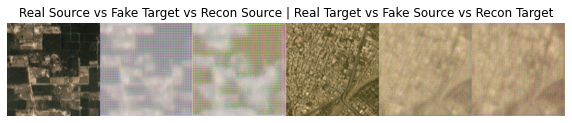

Epoch 1/15 finished at 15:54:12.678619
                [G Loss: 1.9404476881027222]	[D Loss: 59.28519248962402]
identity loss source: 0.4426993131637573
identity loss targ: 0.25587961077690125
wganloss_S: -0.10164230316877365
wganloss_T: -0.1654675006866455
cycle loss source: 0.4677101671695709
cycle loss targ: 0.9450881481170654

identity loss source: 0.23076686263084412
identity loss targ: 0.18793053925037384
wganloss_S: -0.10817153006792068
wganloss_T: -0.17232051491737366
cycle loss source: 0.6211602091789246
cycle loss targ: 0.6315110921859741

identity loss source: 0.6408239006996155
identity loss targ: 0.5879872441291809
wganloss_S: -0.0976766049861908
wganloss_T: -0.18407243490219116
cycle loss source: 1.627000331878662
cycle loss targ: 1.8698149919509888

identity loss source: 0.4179045855998993
identity loss targ: 0.47914519906044006
wganloss_S: -0.08540954440832138
wganloss_T: -0.16244491934776306
cycle loss source: 1.1266727447509766
cycle loss targ: 1.17039155960083

ident

identity loss source: 0.16602681577205658
identity loss targ: 0.137708380818367
wganloss_S: -0.13087892532348633
wganloss_T: -0.18906036019325256
cycle loss source: 0.310289204120636
cycle loss targ: 0.3756774067878723

identity loss source: 0.16699624061584473
identity loss targ: 0.19305945932865143
wganloss_S: -0.12376618385314941
wganloss_T: -0.17676286399364471
cycle loss source: 0.4024982750415802
cycle loss targ: 0.37434035539627075

identity loss source: 0.16599154472351074
identity loss targ: 0.145196795463562
wganloss_S: -0.09622548520565033
wganloss_T: -0.1954043060541153
cycle loss source: 0.32460856437683105
cycle loss targ: 0.38154932856559753

identity loss source: 0.3321055769920349
identity loss targ: 0.2949124276638031
wganloss_S: -0.10477127879858017
wganloss_T: -0.16639693081378937
cycle loss source: 0.6522500514984131
cycle loss targ: 0.69820636510849

identity loss source: 0.2878888249397278
identity loss targ: 0.2554648518562317
wganloss_S: -0.10549405962228775
wg

identity loss source: 0.17580640316009521
identity loss targ: 0.16499102115631104
wganloss_S: -0.11815802752971649
wganloss_T: -0.2094734013080597
cycle loss source: 0.34841296076774597
cycle loss targ: 0.41626590490341187

identity loss source: 0.23276253044605255
identity loss targ: 0.21347688138484955
wganloss_S: -0.130315363407135
wganloss_T: -0.19273944199085236
cycle loss source: 0.5722852349281311
cycle loss targ: 0.5353412628173828

identity loss source: 0.2668156325817108
identity loss targ: 0.22347591817378998
wganloss_S: -0.12871213257312775
wganloss_T: -0.18631714582443237
cycle loss source: 0.49543285369873047
cycle loss targ: 0.5660220980644226

identity loss source: 0.1709519624710083
identity loss targ: 0.22207148373126984
wganloss_S: -0.11647037416696548
wganloss_T: -0.1804025024175644
cycle loss source: 0.6355351209640503
cycle loss targ: 0.3774231970310211

identity loss source: 0.29669448733329773
identity loss targ: 0.20406879484653473
wganloss_S: -0.13270220160484

identity loss source: 0.2664017081260681
identity loss targ: 0.24497544765472412
wganloss_S: -0.15567952394485474
wganloss_T: -0.18676185607910156
cycle loss source: 0.5287485122680664
cycle loss targ: 0.5566176176071167

identity loss source: 0.18688777089118958
identity loss targ: 0.15373645722866058
wganloss_S: -0.17001546919345856
wganloss_T: -0.2007887363433838
cycle loss source: 0.33011478185653687
cycle loss targ: 0.40095722675323486

identity loss source: 0.20493565499782562
identity loss targ: 0.22468620538711548
wganloss_S: -0.16774232685565948
wganloss_T: -0.21191942691802979
cycle loss source: 0.48399263620376587
cycle loss targ: 0.4500434398651123

identity loss source: 0.22981815040111542
identity loss targ: 0.1774453967809677
wganloss_S: -0.17116108536720276
wganloss_T: -0.21931470930576324
cycle loss source: 0.41169312596321106
cycle loss targ: 0.4935697019100189

identity loss source: 0.20301640033721924
identity loss targ: 0.14885053038597107
wganloss_S: -0.1914971768

identity loss source: 0.22812025249004364
identity loss targ: 0.14814214408397675
wganloss_S: -0.1565628945827484
wganloss_T: -0.231575608253479
cycle loss source: 0.3121070861816406
cycle loss targ: 0.47955214977264404

identity loss source: 0.21128955483436584
identity loss targ: 0.2544868290424347
wganloss_S: -0.1762007623910904
wganloss_T: -0.23970460891723633
cycle loss source: 0.5777358412742615
cycle loss targ: 0.44055089354515076

identity loss source: 0.21275779604911804
identity loss targ: 0.12385530769824982
wganloss_S: -0.17504945397377014
wganloss_T: -0.21887703239917755
cycle loss source: 0.25748756527900696
cycle loss targ: 0.4439796507358551

identity loss source: 0.13224634528160095
identity loss targ: 0.18956509232521057
wganloss_S: -0.17930181324481964
wganloss_T: -0.255951851606369
cycle loss source: 0.3881133198738098
cycle loss targ: 0.2710133194923401

identity loss source: 0.1840413212776184
identity loss targ: 0.2192607820034027
wganloss_S: -0.17462238669395447

identity loss source: 0.1997538059949875
identity loss targ: 0.2066645622253418
wganloss_S: -0.16963325440883636
wganloss_T: -0.22561894357204437
cycle loss source: 0.4625288248062134
cycle loss targ: 0.41413581371307373

identity loss source: 0.14027635753154755
identity loss targ: 0.19583764672279358
wganloss_S: -0.15218667685985565
wganloss_T: -0.248042494058609
cycle loss source: 0.42221367359161377
cycle loss targ: 0.2887263894081116

identity loss source: 0.19853946566581726
identity loss targ: 0.11815958470106125
wganloss_S: -0.16586890816688538
wganloss_T: -0.23205488920211792
cycle loss source: 0.26264065504074097
cycle loss targ: 0.4137105345726013

identity loss source: 0.15632149577140808
identity loss targ: 0.17010845243930817
wganloss_S: -0.16696737706661224
wganloss_T: -0.24373063445091248
cycle loss source: 0.35249727964401245
cycle loss targ: 0.3244971036911011

identity loss source: 0.16356827318668365
identity loss targ: 0.11129047721624374
wganloss_S: -0.13657590746

identity loss source: 0.17596572637557983
identity loss targ: 0.15862314403057098
wganloss_S: -0.21766430139541626
wganloss_T: -0.2368694394826889
cycle loss source: 0.3625184893608093
cycle loss targ: 0.378140389919281

identity loss source: 0.15394796431064606
identity loss targ: 0.249761164188385
wganloss_S: -0.21130475401878357
wganloss_T: -0.2232285887002945
cycle loss source: 0.5136797428131104
cycle loss targ: 0.34359508752822876

identity loss source: 0.18364118039608002
identity loss targ: 0.1052967831492424
wganloss_S: -0.17904487252235413
wganloss_T: -0.20898209512233734
cycle loss source: 0.22444656491279602
cycle loss targ: 0.383774071931839

identity loss source: 0.18824759125709534
identity loss targ: 0.11614865809679031
wganloss_S: -0.21064366400241852
wganloss_T: -0.2140287309885025
cycle loss source: 0.25537800788879395
cycle loss targ: 0.4001794457435608

identity loss source: 0.1371554136276245
identity loss targ: 0.11395499110221863
wganloss_S: -0.2229166328907013


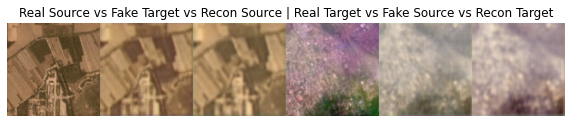

Epoch 1/15 finished at 15:56:52.783697
                [G Loss: 0.68937087059021]	[D Loss: 2.776930570602417]
identity loss source: 0.23332270979881287
identity loss targ: 0.16749964654445648
wganloss_S: -0.20741386711597443
wganloss_T: -0.2302425652742386
cycle loss source: 0.37795737385749817
cycle loss targ: 0.4982662498950958

identity loss source: 0.16904743015766144
identity loss targ: 0.14110182225704193
wganloss_S: -0.19875019788742065
wganloss_T: -0.24262890219688416
cycle loss source: 0.2999405264854431
cycle loss targ: 0.35382184386253357

identity loss source: 0.13210178911685944
identity loss targ: 0.14795860648155212
wganloss_S: -0.193491131067276
wganloss_T: -0.23621225357055664
cycle loss source: 0.3240531086921692
cycle loss targ: 0.289559006690979

identity loss source: 0.13902200758457184
identity loss targ: 0.1364804357290268
wganloss_S: -0.2006019651889801
wganloss_T: -0.24007458984851837
cycle loss source: 0.31849271059036255
cycle loss targ: 0.29225313663482666



identity loss source: 0.12461011111736298
identity loss targ: 0.12907420098781586
wganloss_S: -0.2065235674381256
wganloss_T: -0.23011356592178345
cycle loss source: 0.27628669142723083
cycle loss targ: 0.27457189559936523

identity loss source: 0.1478327214717865
identity loss targ: 0.1383974403142929
wganloss_S: -0.20331566035747528
wganloss_T: -0.23074786365032196
cycle loss source: 0.3494790196418762
cycle loss targ: 0.35691970586776733

identity loss source: 0.1495775431394577
identity loss targ: 0.1136845201253891
wganloss_S: -0.17311736941337585
wganloss_T: -0.20872849225997925
cycle loss source: 0.31864267587661743
cycle loss targ: 0.405910462141037

identity loss source: 0.21213458478450775
identity loss targ: 0.13534820079803467
wganloss_S: -0.18556344509124756
wganloss_T: -0.21763098239898682
cycle loss source: 0.29839110374450684
cycle loss targ: 0.4662771224975586

identity loss source: 0.20941981673240662
identity loss targ: 0.15793320536613464
wganloss_S: -0.152871355414

identity loss source: 0.08990886807441711
identity loss targ: 0.19912751019001007
wganloss_S: -0.17353753745555878
wganloss_T: -0.17542029917240143
cycle loss source: 0.4345241189002991
cycle loss targ: 0.25281593203544617

identity loss source: 0.18637271225452423
identity loss targ: 0.1446017622947693
wganloss_S: -0.18142707645893097
wganloss_T: -0.17860858142375946
cycle loss source: 0.3263379633426666
cycle loss targ: 0.4004301428794861

identity loss source: 0.13443860411643982
identity loss targ: 0.12925425171852112
wganloss_S: -0.1806534230709076
wganloss_T: -0.19650931656360626
cycle loss source: 0.27880406379699707
cycle loss targ: 0.2856826186180115

identity loss source: 0.14901909232139587
identity loss targ: 0.1225145012140274
wganloss_S: -0.20322376489639282
wganloss_T: -0.1831708699464798
cycle loss source: 0.2804342806339264
cycle loss targ: 0.33430609107017517

identity loss source: 0.1736290156841278
identity loss targ: 0.18637575209140778
wganloss_S: -0.2265617847442

identity loss source: 0.15908798575401306
identity loss targ: 0.1696622520685196
wganloss_S: -0.1395338475704193
wganloss_T: -0.22259429097175598
cycle loss source: 0.3846777081489563
cycle loss targ: 0.34198182821273804

identity loss source: 0.15905284881591797
identity loss targ: 0.16544553637504578
wganloss_S: -0.13436613976955414
wganloss_T: -0.21497930586338043
cycle loss source: 0.3727659583091736
cycle loss targ: 0.36494913697242737

identity loss source: 0.16190287470817566
identity loss targ: 0.08863698691129684
wganloss_S: -0.14225207269191742
wganloss_T: -0.21409039199352264
cycle loss source: 0.24348068237304688
cycle loss targ: 0.36454951763153076

identity loss source: 0.14168386161327362
identity loss targ: 0.1199439987540245
wganloss_S: -0.1398557722568512
wganloss_T: -0.20692414045333862
cycle loss source: 0.2803075909614563
cycle loss targ: 0.31642448902130127

identity loss source: 0.14216049015522003
identity loss targ: 0.15652436017990112
wganloss_S: -0.1198456287

identity loss source: 0.13246425986289978
identity loss targ: 0.11972299218177795
wganloss_S: -0.2723546326160431
wganloss_T: -0.14665599167346954
cycle loss source: 0.2615845203399658
cycle loss targ: 0.2760484516620636

identity loss source: 0.12518779933452606
identity loss targ: 0.11752557754516602
wganloss_S: -0.24979016184806824
wganloss_T: -0.14831587672233582
cycle loss source: 0.2582165002822876
cycle loss targ: 0.2684163451194763

identity loss source: 0.19912856817245483
identity loss targ: 0.12616579234600067
wganloss_S: -0.22984501719474792
wganloss_T: -0.16870476305484772
cycle loss source: 0.30968233942985535
cycle loss targ: 0.4391162097454071

identity loss source: 0.15816964209079742
identity loss targ: 0.1430465579032898
wganloss_S: -0.24748705327510834
wganloss_T: -0.17105351388454437
cycle loss source: 0.31720831990242004
cycle loss targ: 0.34344375133514404

identity loss source: 0.1881357729434967
identity loss targ: 0.11966435611248016
wganloss_S: -0.24502015113

identity loss source: 0.13635815680027008
identity loss targ: 0.13318994641304016
wganloss_S: -0.17830073833465576
wganloss_T: -0.23516343533992767
cycle loss source: 0.29980266094207764
cycle loss targ: 0.32262277603149414

identity loss source: 0.149501234292984
identity loss targ: 0.08765935897827148
wganloss_S: -0.19684164226055145
wganloss_T: -0.23112119734287262
cycle loss source: 0.2165757417678833
cycle loss targ: 0.31303173303604126

identity loss source: 0.1406411975622177
identity loss targ: 0.10918571799993515
wganloss_S: -0.20320598781108856
wganloss_T: -0.23468442261219025
cycle loss source: 0.24538365006446838
cycle loss targ: 0.3095344305038452

identity loss source: 0.13044607639312744
identity loss targ: 0.13506671786308289
wganloss_S: -0.19679786264896393
wganloss_T: -0.2549877166748047
cycle loss source: 0.3047855496406555
cycle loss targ: 0.29055365920066833

identity loss source: 0.16222117841243744
identity loss targ: 0.16560731828212738
wganloss_S: -0.1807898432

identity loss source: 0.14977037906646729
identity loss targ: 0.12382804602384567
wganloss_S: -0.2254452407360077
wganloss_T: -0.18010352551937103
cycle loss source: 0.2739124298095703
cycle loss targ: 0.341587632894516

identity loss source: 0.1448877453804016
identity loss targ: 0.11720898747444153
wganloss_S: -0.2357775866985321
wganloss_T: -0.21519741415977478
cycle loss source: 0.252159059047699
cycle loss targ: 0.3069474995136261

identity loss source: 0.13820575177669525
identity loss targ: 0.1532207429409027
wganloss_S: -0.17821858823299408
wganloss_T: -0.18072713911533356
cycle loss source: 0.3614763021469116
cycle loss targ: 0.2861601710319519

identity loss source: 0.17603985965251923
identity loss targ: 0.12622153759002686
wganloss_S: -0.15143220126628876
wganloss_T: -0.18642018735408783
cycle loss source: 0.29817071557044983
cycle loss targ: 0.3642752766609192

identity loss source: 0.19297310709953308
identity loss targ: 0.12830208241939545
wganloss_S: -0.1667030751705169

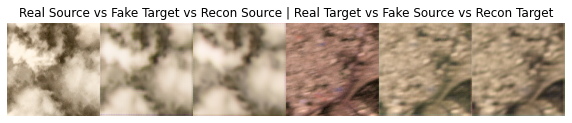

Epoch 1/15 finished at 15:59:30.591538
                [G Loss: 0.8023916482925415]	[D Loss: 0.639421284198761]
identity loss source: 0.1977977156639099
identity loss targ: 0.14103572070598602
wganloss_S: -0.0676770731806755
wganloss_T: -0.18355540931224823
cycle loss source: 0.3511267602443695
cycle loss targ: 0.5027137994766235

identity loss source: 0.17900559306144714
identity loss targ: 0.14849603176116943
wganloss_S: -0.08130546659231186
wganloss_T: -0.18951348960399628
cycle loss source: 0.35314756631851196
cycle loss targ: 0.4055039882659912

identity loss source: 0.12619264423847198
identity loss targ: 0.1341116726398468
wganloss_S: -0.1013939157128334
wganloss_T: -0.21156731247901917
cycle loss source: 0.2900540232658386
cycle loss targ: 0.2861284911632538

identity loss source: 0.13716521859169006
identity loss targ: 0.152117058634758
wganloss_S: -0.07630501687526703
wganloss_T: -0.17687077820301056
cycle loss source: 0.3562624454498291
cycle loss targ: 0.298611044883728

id

identity loss source: 0.13114526867866516
identity loss targ: 0.15799614787101746
wganloss_S: -0.11581576615571976
wganloss_T: -0.19836600124835968
cycle loss source: 0.337166428565979
cycle loss targ: 0.28105658292770386

identity loss source: 0.1722714900970459
identity loss targ: 0.09913767874240875
wganloss_S: -0.10098417103290558
wganloss_T: -0.185673788189888
cycle loss source: 0.21948517858982086
cycle loss targ: 0.36746543645858765

identity loss source: 0.11346308887004852
identity loss targ: 0.11516337096691132
wganloss_S: -0.08249236643314362
wganloss_T: -0.18441665172576904
cycle loss source: 0.2564566731452942
cycle loss targ: 0.26538950204849243

identity loss source: 0.11745218187570572
identity loss targ: 0.1265573650598526
wganloss_S: -0.06700284779071808
wganloss_T: -0.19381873309612274
cycle loss source: 0.2904248833656311
cycle loss targ: 0.2729411721229553

identity loss source: 0.11413213610649109
identity loss targ: 0.1385980248451233
wganloss_S: -0.0624218694865

identity loss source: 0.2196512520313263
identity loss targ: 0.11583349108695984
wganloss_S: -0.038038674741983414
wganloss_T: -0.18283602595329285
cycle loss source: 0.28186413645744324
cycle loss targ: 0.4607228636741638

identity loss source: 0.1260848492383957
identity loss targ: 0.12179189175367355
wganloss_S: -0.06227514520287514
wganloss_T: -0.167313352227211
cycle loss source: 0.2712286710739136
cycle loss targ: 0.2659277319908142

identity loss source: 0.14210595190525055
identity loss targ: 0.0888989046216011
wganloss_S: -0.06350291520357132
wganloss_T: -0.19652608036994934
cycle loss source: 0.19255539774894714
cycle loss targ: 0.30093953013420105

identity loss source: 0.14938868582248688
identity loss targ: 0.104108065366745
wganloss_S: -0.07558310776948929
wganloss_T: -0.1763789802789688
cycle loss source: 0.256484717130661
cycle loss targ: 0.32336530089378357

identity loss source: 0.17135289311408997
identity loss targ: 0.13893279433250427
wganloss_S: -0.071972198784351

identity loss source: 0.14980101585388184
identity loss targ: 0.08577965199947357
wganloss_S: 0.004618483129888773
wganloss_T: -0.24940550327301025
cycle loss source: 0.19120165705680847
cycle loss targ: 0.3404124081134796

identity loss source: 0.12596377730369568
identity loss targ: 0.082573302090168
wganloss_S: 0.017358696088194847
wganloss_T: -0.24096082150936127
cycle loss source: 0.2001563459634781
cycle loss targ: 0.27077141404151917

identity loss source: 0.15021377801895142
identity loss targ: 0.11880296468734741
wganloss_S: 0.011405942030251026
wganloss_T: -0.22465774416923523
cycle loss source: 0.26414963603019714
cycle loss targ: 0.34004729986190796

identity loss source: 0.15953750908374786
identity loss targ: 0.12401319295167923
wganloss_S: 0.024484220892190933
wganloss_T: -0.23430867493152618
cycle loss source: 0.2723197638988495
cycle loss targ: 0.3424343764781952

identity loss source: 0.12641730904579163
identity loss targ: 0.13630619645118713
wganloss_S: 0.0190720167

identity loss source: 0.1401163935661316
identity loss targ: 0.15936234593391418
wganloss_S: -0.08196131139993668
wganloss_T: -0.22107906639575958
cycle loss source: 0.3394615054130554
cycle loss targ: 0.30881306529045105

identity loss source: 0.1017618328332901
identity loss targ: 0.12948834896087646
wganloss_S: -0.08982988446950912
wganloss_T: -0.21913477778434753
cycle loss source: 0.2815958261489868
cycle loss targ: 0.21116791665554047

identity loss source: 0.15725302696228027
identity loss targ: 0.1315060406923294
wganloss_S: -0.08497831225395203
wganloss_T: -0.24154958128929138
cycle loss source: 0.2796522378921509
cycle loss targ: 0.33077895641326904

identity loss source: 0.14626356959342957
identity loss targ: 0.0879177525639534
wganloss_S: -0.0763058066368103
wganloss_T: -0.22864028811454773
cycle loss source: 0.20118103921413422
cycle loss targ: 0.30699002742767334

identity loss source: 0.139398455619812
identity loss targ: 0.10009848326444626
wganloss_S: -0.0810337662696

identity loss source: 0.08757617324590683
identity loss targ: 0.13559487462043762
wganloss_S: -0.006046525668352842
wganloss_T: -0.224345862865448
cycle loss source: 0.29739493131637573
cycle loss targ: 0.1869226098060608

identity loss source: 0.15342174470424652
identity loss targ: 0.09640710055828094
wganloss_S: -0.037190042436122894
wganloss_T: -0.2549229562282562
cycle loss source: 0.22134405374526978
cycle loss targ: 0.32258304953575134

identity loss source: 0.11701907217502594
identity loss targ: 0.13425135612487793
wganloss_S: -0.03875923529267311
wganloss_T: -0.24928155541419983
cycle loss source: 0.28754618763923645
cycle loss targ: 0.2404090166091919

identity loss source: 0.11211831122636795
identity loss targ: 0.07159340381622314
wganloss_S: -0.04898852854967117
wganloss_T: -0.2575347125530243
cycle loss source: 0.1519368439912796
cycle loss targ: 0.23276254534721375

identity loss source: 0.1559157520532608
identity loss targ: 0.05631830915808678
wganloss_S: -0.053264461

identity loss source: 0.15188606083393097
identity loss targ: 0.11683278530836105
wganloss_S: -0.06353671848773956
wganloss_T: -0.21756413578987122
cycle loss source: 0.26748839020729065
cycle loss targ: 0.33501875400543213

identity loss source: 0.09893904626369476
identity loss targ: 0.10052304714918137
wganloss_S: -0.10332252830266953
wganloss_T: -0.1956285983324051
cycle loss source: 0.2867053151130676
cycle loss targ: 0.2617589235305786

identity loss source: 0.13142648339271545
identity loss targ: 0.16801781952381134
wganloss_S: -0.10918505489826202
wganloss_T: -0.20102274417877197
cycle loss source: 0.4224739074707031
cycle loss targ: 0.3692895770072937

identity loss source: 0.14491209387779236
identity loss targ: 0.08244240283966064
wganloss_S: -0.09151306003332138
wganloss_T: -0.20358259975910187
cycle loss source: 0.20718403160572052
cycle loss targ: 0.3479712903499603

identity loss source: 0.17997607588768005
identity loss targ: 0.13495208323001862
wganloss_S: -0.084359638

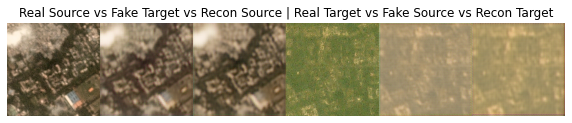

Epoch 1/15 finished at 16:02:07.652704
                [G Loss: 0.5853583216667175]	[D Loss: 2.2833659648895264]
identity loss source: 0.13967269659042358
identity loss targ: 0.07948434352874756
wganloss_S: -0.031655002385377884
wganloss_T: -0.23277126252651215
cycle loss source: 0.1926034539937973
cycle loss targ: 0.2990456521511078

identity loss source: 0.18648357689380646
identity loss targ: 0.10128513723611832
wganloss_S: -0.06942694634199142
wganloss_T: -0.23278571665287018
cycle loss source: 0.23886430263519287
cycle loss targ: 0.391775518655777

identity loss source: 0.13353875279426575
identity loss targ: 0.09886211156845093
wganloss_S: -0.08780328929424286
wganloss_T: -0.24390606582164764
cycle loss source: 0.22014197707176208
cycle loss targ: 0.2883838415145874

identity loss source: 0.13286778330802917
identity loss targ: 0.13413091003894806
wganloss_S: -0.05141369625926018
wganloss_T: -0.23697379231452942
cycle loss source: 0.305597186088562
cycle loss targ: 0.316381812095

identity loss source: 0.19722387194633484
identity loss targ: 0.15226420760154724
wganloss_S: -0.0424627959728241
wganloss_T: -0.34549784660339355
cycle loss source: 0.3225519061088562
cycle loss targ: 0.4062178432941437

identity loss source: 0.1587977111339569
identity loss targ: 0.1240159124135971
wganloss_S: -0.01379480678588152
wganloss_T: -0.3286004364490509
cycle loss source: 0.26005756855010986
cycle loss targ: 0.3272775113582611

identity loss source: 0.09757481515407562
identity loss targ: 0.10055181384086609
wganloss_S: -0.003822881728410721
wganloss_T: -0.316118061542511
cycle loss source: 0.21300122141838074
cycle loss targ: 0.20643940567970276

identity loss source: 0.07964562624692917
identity loss targ: 0.10361805558204651
wganloss_S: -0.007964327931404114
wganloss_T: -0.30291271209716797
cycle loss source: 0.22473549842834473
cycle loss targ: 0.17205776274204254

identity loss source: 0.2023383229970932
identity loss targ: 0.11918270587921143
wganloss_S: -0.00870826933

identity loss source: 0.14461754262447357
identity loss targ: 0.12242799997329712
wganloss_S: -0.028881188482046127
wganloss_T: -0.33984503149986267
cycle loss source: 0.2706754207611084
cycle loss targ: 0.3005586266517639

identity loss source: 0.11825907230377197
identity loss targ: 0.07548446208238602
wganloss_S: 0.030343014746904373
wganloss_T: -0.3525390028953552
cycle loss source: 0.15811225771903992
cycle loss targ: 0.2422930896282196

identity loss source: 0.11037800461053848
identity loss targ: 0.1238073855638504
wganloss_S: 0.041506171226501465
wganloss_T: -0.3483635485172272
cycle loss source: 0.260621041059494
cycle loss targ: 0.22875100374221802

identity loss source: 0.14086158573627472
identity loss targ: 0.16517096757888794
wganloss_S: 0.03434038162231445
wganloss_T: -0.35370320081710815
cycle loss source: 0.3500347137451172
cycle loss targ: 0.28969860076904297

identity loss source: 0.107921302318573
identity loss targ: 0.06230880320072174
wganloss_S: 0.036539882421493

identity loss source: 0.14190760254859924
identity loss targ: 0.10594803839921951
wganloss_S: 0.014126678928732872
wganloss_T: -0.25866425037384033
cycle loss source: 0.22535958886146545
cycle loss targ: 0.2933226227760315

identity loss source: 0.092870332300663
identity loss targ: 0.09446438401937485
wganloss_S: 0.01696452684700489
wganloss_T: -0.24435840547084808
cycle loss source: 0.19869187474250793
cycle loss targ: 0.19293341040611267

identity loss source: 0.1539396047592163
identity loss targ: 0.13526278734207153
wganloss_S: 0.011640808545053005
wganloss_T: -0.27057984471321106
cycle loss source: 0.2849973440170288
cycle loss targ: 0.3183910846710205

identity loss source: 0.14687307178974152
identity loss targ: 0.11142933368682861
wganloss_S: 0.00999273732304573
wganloss_T: -0.25628554821014404
cycle loss source: 0.23223742842674255
cycle loss targ: 0.3069649934768677

identity loss source: 0.10323778539896011
identity loss targ: 0.10581546276807785
wganloss_S: 0.0187816619873

identity loss source: 0.117467500269413
identity loss targ: 0.1242527961730957
wganloss_S: 0.03013121336698532
wganloss_T: -0.25050896406173706
cycle loss source: 0.2887181341648102
cycle loss targ: 0.27026131749153137

identity loss source: 0.11450538039207458
identity loss targ: 0.1264897733926773
wganloss_S: 0.021360525861382484
wganloss_T: -0.24797575175762177
cycle loss source: 0.2661701738834381
cycle loss targ: 0.25153136253356934

identity loss source: 0.1941804587841034
identity loss targ: 0.08961689472198486
wganloss_S: 0.030122360214591026
wganloss_T: -0.25487619638442993
cycle loss source: 0.20042535662651062
cycle loss targ: 0.40894266963005066

identity loss source: 0.10448496043682098
identity loss targ: 0.08734861016273499
wganloss_S: 0.0350259505212307
wganloss_T: -0.23488202691078186
cycle loss source: 0.19581900537014008
cycle loss targ: 0.22946147620677948

identity loss source: 0.13640955090522766
identity loss targ: 0.09993311017751694
wganloss_S: 0.03950452804565

identity loss source: 0.11805292218923569
identity loss targ: 0.14148129522800446
wganloss_S: -0.05948908254504204
wganloss_T: -0.2838366627693176
cycle loss source: 0.3087728023529053
cycle loss targ: 0.24210476875305176

identity loss source: 0.14925558865070343
identity loss targ: 0.11379759013652802
wganloss_S: -0.015713917091488838
wganloss_T: -0.30253568291664124
cycle loss source: 0.25567197799682617
cycle loss targ: 0.3173021674156189

identity loss source: 0.10384756326675415
identity loss targ: 0.11760057508945465
wganloss_S: 0.014153329655528069
wganloss_T: -0.3094280958175659
cycle loss source: 0.25102752447128296
cycle loss targ: 0.2246285229921341

identity loss source: 0.15533091127872467
identity loss targ: 0.13072234392166138
wganloss_S: 0.0067405118606984615
wganloss_T: -0.2941908538341522
cycle loss source: 0.28975173830986023
cycle loss targ: 0.32365158200263977

identity loss source: 0.14329293370246887
identity loss targ: 0.12685313820838928
wganloss_S: 0.00372588

identity loss source: 0.11191381514072418
identity loss targ: 0.16459685564041138
wganloss_S: -0.06222217530012131
wganloss_T: -0.3658915162086487
cycle loss source: 0.3790249228477478
cycle loss targ: 0.263826847076416

identity loss source: 0.20022960007190704
identity loss targ: 0.14829809963703156
wganloss_S: -0.052822552621364594
wganloss_T: -0.360533207654953
cycle loss source: 0.3925821781158447
cycle loss targ: 0.5106065273284912

identity loss source: 0.11089112609624863
identity loss targ: 0.12717504799365997
wganloss_S: -0.0520838126540184
wganloss_T: -0.35466405749320984
cycle loss source: 0.32916659116744995
cycle loss targ: 0.2830733060836792

identity loss source: 0.12541653215885162
identity loss targ: 0.11592722684144974
wganloss_S: -0.06203985959291458
wganloss_T: -0.3624476194381714
cycle loss source: 0.26775288581848145
cycle loss targ: 0.282761812210083

identity loss source: 0.14735901355743408
identity loss targ: 0.09744438529014587
wganloss_S: -0.069785714149475

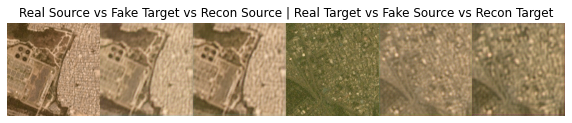

Epoch 1/15 finished at 16:04:44.933288
                [G Loss: 0.461653470993042]	[D Loss: 0.7186805903911591]
identity loss source: 0.106808602809906
identity loss targ: 0.13525085151195526
wganloss_S: -0.023264141753315926
wganloss_T: -0.3418578803539276
cycle loss source: 0.32546016573905945
cycle loss targ: 0.24891065061092377

identity loss source: 0.143761545419693
identity loss targ: 0.14180874824523926
wganloss_S: -0.05700874328613281
wganloss_T: -0.35222670435905457
cycle loss source: 0.32824650406837463
cycle loss targ: 0.325962632894516

identity loss source: 0.09224016219377518
identity loss targ: 0.12343065440654755
wganloss_S: -0.04131406918168068
wganloss_T: -0.36812952160835266
cycle loss source: 0.27103951573371887
cycle loss targ: 0.19150541722774506

identity loss source: 0.13100562989711761
identity loss targ: 0.13437195122241974
wganloss_S: -0.05446295812726021
wganloss_T: -0.37912747263908386
cycle loss source: 0.2951340675354004
cycle loss targ: 0.29553714394569

identity loss source: 0.07306957989931107
identity loss targ: 0.11403944343328476
wganloss_S: -0.029119396582245827
wganloss_T: -0.30087336897850037
cycle loss source: 0.24676451086997986
cycle loss targ: 0.15774555504322052

identity loss source: 0.12243971973657608
identity loss targ: 0.13652054965496063
wganloss_S: 0.011332454159855843
wganloss_T: -0.3065135180950165
cycle loss source: 0.3038787245750427
cycle loss targ: 0.26394641399383545

identity loss source: 0.11583562195301056
identity loss targ: 0.09800753742456436
wganloss_S: -0.010569638572633266
wganloss_T: -0.32068130373954773
cycle loss source: 0.21539026498794556
cycle loss targ: 0.24891211092472076

identity loss source: 0.14214663207530975
identity loss targ: 0.12908856570720673
wganloss_S: 0.009943817742168903
wganloss_T: -0.33184197545051575
cycle loss source: 0.27810561656951904
cycle loss targ: 0.3040069043636322

identity loss source: 0.1430431604385376
identity loss targ: 0.07662051916122437
wganloss_S: -0.02570

identity loss source: 0.0977611243724823
identity loss targ: 0.12075650691986084
wganloss_S: 0.07705754786729813
wganloss_T: -0.3558667302131653
cycle loss source: 0.31933408975601196
cycle loss targ: 0.26658061146736145

identity loss source: 0.12468304485082626
identity loss targ: 0.11527159065008163
wganloss_S: 0.08592817932367325
wganloss_T: -0.3626064956188202
cycle loss source: 0.2940669655799866
cycle loss targ: 0.28593528270721436

identity loss source: 0.12059809267520905
identity loss targ: 0.0947827696800232
wganloss_S: 0.07797367125749588
wganloss_T: -0.3716159462928772
cycle loss source: 0.20788447558879852
cycle loss targ: 0.25761765241622925

identity loss source: 0.12205272912979126
identity loss targ: 0.08414575457572937
wganloss_S: 0.1398794800043106
wganloss_T: -0.3549383580684662
cycle loss source: 0.20386666059494019
cycle loss targ: 0.2552448809146881

identity loss source: 0.11944955587387085
identity loss targ: 0.14370590448379517
wganloss_S: 0.1442328244447708


identity loss source: 0.14485178887844086
identity loss targ: 0.11810041218996048
wganloss_S: 0.10042998194694519
wganloss_T: -0.36298590898513794
cycle loss source: 0.2487880289554596
cycle loss targ: 0.29887571930885315

identity loss source: 0.1518869251012802
identity loss targ: 0.10982047021389008
wganloss_S: 0.10070531815290451
wganloss_T: -0.3721955418586731
cycle loss source: 0.23440001904964447
cycle loss targ: 0.3154556453227997

identity loss source: 0.1224747896194458
identity loss targ: 0.1354503333568573
wganloss_S: 0.10236839950084686
wganloss_T: -0.4063936173915863
cycle loss source: 0.2864857316017151
cycle loss targ: 0.2526848316192627

identity loss source: 0.127829909324646
identity loss targ: 0.11853198707103729
wganloss_S: 0.10816099494695663
wganloss_T: -0.40592771768569946
cycle loss source: 0.25675031542778015
cycle loss targ: 0.26403242349624634

identity loss source: 0.11548902839422226
identity loss targ: 0.12545736134052277
wganloss_S: 0.11221438646316528
w

identity loss source: 0.10891714692115784
identity loss targ: 0.10707799345254898
wganloss_S: 0.09320057928562164
wganloss_T: -0.3492264449596405
cycle loss source: 0.2252066433429718
cycle loss targ: 0.23545606434345245

identity loss source: 0.12359853088855743
identity loss targ: 0.09028272330760956
wganloss_S: 0.09451571851968765
wganloss_T: -0.3444545269012451
cycle loss source: 0.20033800601959229
cycle loss targ: 0.26382210850715637

identity loss source: 0.09381259977817535
identity loss targ: 0.10353702306747437
wganloss_S: 0.11009449511766434
wganloss_T: -0.3227698802947998
cycle loss source: 0.2214091718196869
cycle loss targ: 0.20138311386108398

identity loss source: 0.08665018528699875
identity loss targ: 0.09935368597507477
wganloss_S: 0.0956459492444992
wganloss_T: -0.32283419370651245
cycle loss source: 0.22161760926246643
cycle loss targ: 0.18955691158771515

identity loss source: 0.13081474602222443
identity loss targ: 0.10814531147480011
wganloss_S: 0.12470490485429

identity loss source: 0.11782222986221313
identity loss targ: 0.08840544521808624
wganloss_S: 0.06205026060342789
wganloss_T: -0.30413708090782166
cycle loss source: 0.186038538813591
cycle loss targ: 0.24519534409046173

identity loss source: 0.1066250279545784
identity loss targ: 0.09337235987186432
wganloss_S: 0.06309116631746292
wganloss_T: -0.3253430724143982
cycle loss source: 0.19651593267917633
cycle loss targ: 0.22405238449573517

identity loss source: 0.09911757707595825
identity loss targ: 0.1010141596198082
wganloss_S: 0.0812063217163086
wganloss_T: -0.3410336971282959
cycle loss source: 0.22122405469417572
cycle loss targ: 0.20764954388141632

identity loss source: 0.09509045630693436
identity loss targ: 0.09531007707118988
wganloss_S: 0.08224744349718094
wganloss_T: -0.3485662341117859
cycle loss source: 0.20873792469501495
cycle loss targ: 0.2043229192495346

identity loss source: 0.11491279304027557
identity loss targ: 0.1345546692609787
wganloss_S: 0.08559200167655945


identity loss source: 0.161588653922081
identity loss targ: 0.09607093036174774
wganloss_S: 0.06771328300237656
wganloss_T: -0.3759766221046448
cycle loss source: 0.21757474541664124
cycle loss targ: 0.33641889691352844

identity loss source: 0.10082312673330307
identity loss targ: 0.1151234358549118
wganloss_S: 0.17963825166225433
wganloss_T: -0.39535629749298096
cycle loss source: 0.24906931817531586
cycle loss targ: 0.2122921347618103

identity loss source: 0.11468099057674408
identity loss targ: 0.1263444721698761
wganloss_S: 0.1886148303747177
wganloss_T: -0.4068116545677185
cycle loss source: 0.2753008008003235
cycle loss targ: 0.24619948863983154

identity loss source: 0.10808560997247696
identity loss targ: 0.12350490689277649
wganloss_S: 0.17528940737247467
wganloss_T: -0.3982706665992737
cycle loss source: 0.2710941731929779
cycle loss targ: 0.23224645853042603

identity loss source: 0.12164868414402008
identity loss targ: 0.10443231463432312
wganloss_S: 0.18789997696876526
w

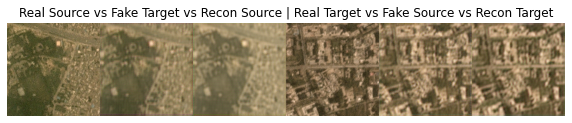

Epoch 1/15 finished at 16:07:22.104834
                [G Loss: 0.5059354305267334]	[D Loss: 1.2779422104358673]
identity loss source: 0.1299811750650406
identity loss targ: 0.10408087819814682
wganloss_S: 0.14601120352745056
wganloss_T: -0.41456401348114014
cycle loss source: 0.22605261206626892
cycle loss targ: 0.2755139172077179

identity loss source: 0.10828801244497299
identity loss targ: 0.11394521594047546
wganloss_S: 0.15409328043460846
wganloss_T: -0.4130171239376068
cycle loss source: 0.2416810542345047
cycle loss targ: 0.22663089632987976

identity loss source: 0.09545351564884186
identity loss targ: 0.09725987166166306
wganloss_S: 0.12497886270284653
wganloss_T: -0.4093456268310547
cycle loss source: 0.21998105943202972
cycle loss targ: 0.20092535018920898

identity loss source: 0.08513975143432617
identity loss targ: 0.06699399650096893
wganloss_S: 0.1591283082962036
wganloss_T: -0.3944950997829437
cycle loss source: 0.14821577072143555
cycle loss targ: 0.17618843913078308

identity loss source: 0.12019751965999603
identity loss targ: 0.0926964059472084
wganloss_S: 0.17741893231868744
wganloss_T: -0.3648114502429962
cycle loss source: 0.20848917961120605
cycle loss targ: 0.2663154900074005

identity loss source: 0.1109468936920166
identity loss targ: 0.1537816971540451
wganloss_S: 0.172109454870224
wganloss_T: -0.37826836109161377
cycle loss source: 0.33281370997428894
cycle loss targ: 0.23924487829208374

identity loss source: 0.09968482702970505
identity loss targ: 0.08550786226987839
wganloss_S: 0.17525622248649597
wganloss_T: -0.37090569734573364
cycle loss source: 0.1895289421081543
cycle loss targ: 0.21291078627109528

identity loss source: 0.12655523419380188
identity loss targ: 0.10973785072565079
wganloss_S: 0.17535343766212463
wganloss_T: -0.3730737864971161
cycle loss source: 0.2480386197566986
cycle loss targ: 0.27943098545074463

identity loss source: 0.14752595126628876
identity loss targ: 0.07001495361328125
wganloss_S: 0.17298895120620728


identity loss source: 0.12897956371307373
identity loss targ: 0.07816258072853088
wganloss_S: 0.12617243826389313
wganloss_T: -0.3265560567378998
cycle loss source: 0.1756487786769867
cycle loss targ: 0.28954216837882996

identity loss source: 0.08674255758523941
identity loss targ: 0.10003339499235153
wganloss_S: 0.1286737322807312
wganloss_T: -0.2865535020828247
cycle loss source: 0.22441433370113373
cycle loss targ: 0.18801337480545044

identity loss source: 0.10977503657341003
identity loss targ: 0.08090262115001678
wganloss_S: 0.14728933572769165
wganloss_T: -0.2507142126560211
cycle loss source: 0.18528607487678528
cycle loss targ: 0.24717910587787628

identity loss source: 0.12218392640352249
identity loss targ: 0.11151708662509918
wganloss_S: 0.17769567668437958
wganloss_T: -0.2853100597858429
cycle loss source: 0.25820907950401306
cycle loss targ: 0.2823498547077179

identity loss source: 0.09986073523759842
identity loss targ: 0.11907375603914261
wganloss_S: 0.191438466310501

identity loss source: 0.11694678664207458
identity loss targ: 0.06916853040456772
wganloss_S: 0.19012700021266937
wganloss_T: -0.409415602684021
cycle loss source: 0.1639111489057541
cycle loss targ: 0.24203842878341675

identity loss source: 0.10367603600025177
identity loss targ: 0.10013937205076218
wganloss_S: 0.19456778466701508
wganloss_T: -0.4045683741569519
cycle loss source: 0.21519771218299866
cycle loss targ: 0.22060216963291168

identity loss source: 0.08865869045257568
identity loss targ: 0.08636562526226044
wganloss_S: 0.20001818239688873
wganloss_T: -0.41298481822013855
cycle loss source: 0.1939442902803421
cycle loss targ: 0.20838454365730286

identity loss source: 0.10144956409931183
identity loss targ: 0.09654857218265533
wganloss_S: 0.18647347390651703
wganloss_T: -0.42178013920783997
cycle loss source: 0.2299973964691162
cycle loss targ: 0.23551075160503387

identity loss source: 0.08533761650323868
identity loss targ: 0.09001843631267548
wganloss_S: 0.20841617882251

identity loss source: 0.15720440447330475
identity loss targ: 0.08302100002765656
wganloss_S: 0.17488206923007965
wganloss_T: -0.4410896301269531
cycle loss source: 0.21965661644935608
cycle loss targ: 0.38732674717903137

identity loss source: 0.08676037937402725
identity loss targ: 0.12265644967556
wganloss_S: 0.15774571895599365
wganloss_T: -0.4382477402687073
cycle loss source: 0.29432567954063416
cycle loss targ: 0.1949237883090973

identity loss source: 0.14016149938106537
identity loss targ: 0.08900055289268494
wganloss_S: 0.14695870876312256
wganloss_T: -0.4523541331291199
cycle loss source: 0.1896631121635437
cycle loss targ: 0.2938501536846161

identity loss source: 0.1191120594739914
identity loss targ: 0.10861839354038239
wganloss_S: 0.210352823138237
wganloss_T: -0.45347240567207336
cycle loss source: 0.23684106767177582
cycle loss targ: 0.274053156375885

identity loss source: 0.14941367506980896
identity loss targ: 0.0863741934299469
wganloss_S: 0.20967428386211395
wganl

identity loss source: 0.07516283541917801
identity loss targ: 0.09439817070960999
wganloss_S: 0.2182934433221817
wganloss_T: -0.4736725091934204
cycle loss source: 0.20239122211933136
cycle loss targ: 0.15590745210647583

identity loss source: 0.10560274124145508
identity loss targ: 0.09131579846143723
wganloss_S: 0.23618611693382263
wganloss_T: -0.4725383520126343
cycle loss source: 0.20778246223926544
cycle loss targ: 0.23973600566387177

identity loss source: 0.12056344002485275
identity loss targ: 0.14813941717147827
wganloss_S: 0.21713761985301971
wganloss_T: -0.4604458808898926
cycle loss source: 0.3227493464946747
cycle loss targ: 0.26557114720344543

identity loss source: 0.08488985896110535
identity loss targ: 0.08437968790531158
wganloss_S: 0.21367810666561127
wganloss_T: -0.4510498642921448
cycle loss source: 0.19359347224235535
cycle loss targ: 0.18637368083000183

identity loss source: 0.12337390333414078
identity loss targ: 0.08614622801542282
wganloss_S: 0.23050825297832

identity loss source: 0.09859955310821533
identity loss targ: 0.09214407950639725
wganloss_S: 0.3067554831504822
wganloss_T: -0.4670560359954834
cycle loss source: 0.20966754853725433
cycle loss targ: 0.23182231187820435

identity loss source: 0.10713668167591095
identity loss targ: 0.0779774859547615
wganloss_S: 0.2702704071998596
wganloss_T: -0.42894965410232544
cycle loss source: 0.21608304977416992
cycle loss targ: 0.24994193017482758

identity loss source: 0.1287524253129959
identity loss targ: 0.0937451720237732
wganloss_S: 0.2526635229587555
wganloss_T: -0.47112342715263367
cycle loss source: 0.23488518595695496
cycle loss targ: 0.2871055006980896

identity loss source: 0.06609923392534256
identity loss targ: 0.11022105067968369
wganloss_S: 0.2550501525402069
wganloss_T: -0.46387580037117004
cycle loss source: 0.2394639104604721
cycle loss targ: 0.14861717820167542

identity loss source: 0.11930029839277267
identity loss targ: 0.08667798340320587
wganloss_S: 0.24633051455020905


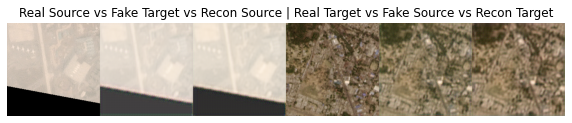

Epoch 1/15 finished at 16:09:59.402277
                [G Loss: 0.46612176299095154]	[D Loss: 0.47838278114795685]
identity loss source: 0.14365625381469727
identity loss targ: 0.08881683647632599
wganloss_S: 0.285300076007843
wganloss_T: -0.45795968174934387
cycle loss source: 0.2088426798582077
cycle loss targ: 0.3158087134361267

identity loss source: 0.10330875217914581
identity loss targ: 0.11753088235855103
wganloss_S: 0.2724381685256958
wganloss_T: -0.4303990304470062
cycle loss source: 0.261648029088974
cycle loss targ: 0.23488140106201172

identity loss source: 0.07838118076324463
identity loss targ: 0.08875502645969391
wganloss_S: 0.2684836983680725
wganloss_T: -0.42214348912239075
cycle loss source: 0.2050991952419281
cycle loss targ: 0.16325661540031433

identity loss source: 0.11810214072465897
identity loss targ: 0.07163631916046143
wganloss_S: 0.2574104964733124
wganloss_T: -0.44166100025177
cycle loss source: 0.16850927472114563
cycle loss targ: 0.2511364817619324

iden

identity loss source: 0.1430622935295105
identity loss targ: 0.10510814189910889
wganloss_S: 0.28708603978157043
wganloss_T: -0.4354219436645508
cycle loss source: 0.26792141795158386
cycle loss targ: 0.3236300051212311

identity loss source: 0.12605233490467072
identity loss targ: 0.11647633463144302
wganloss_S: 0.26682963967323303
wganloss_T: -0.4326050877571106
cycle loss source: 0.35280734300613403
cycle loss targ: 0.28894931077957153

identity loss source: 0.10085716098546982
identity loss targ: 0.0719396248459816
wganloss_S: 0.26472142338752747
wganloss_T: -0.42159315943717957
cycle loss source: 0.1664448082447052
cycle loss targ: 0.22588588297367096

identity loss source: 0.09443220496177673
identity loss targ: 0.12801367044448853
wganloss_S: 0.28014156222343445
wganloss_T: -0.4054345190525055
cycle loss source: 0.3159230649471283
cycle loss targ: 0.2420104742050171

identity loss source: 0.11584331095218658
identity loss targ: 0.13223902881145477
wganloss_S: 0.2906830310821533


identity loss source: 0.1271510124206543
identity loss targ: 0.09421463310718536
wganloss_S: 0.25297412276268005
wganloss_T: -0.4631679356098175
cycle loss source: 0.203551784157753
cycle loss targ: 0.27879199385643005

identity loss source: 0.10557148605585098
identity loss targ: 0.0879167690873146
wganloss_S: 0.272198885679245
wganloss_T: -0.45299360156059265
cycle loss source: 0.1983223557472229
cycle loss targ: 0.2312842756509781

identity loss source: 0.10981335490942001
identity loss targ: 0.069575734436512
wganloss_S: 0.30056628584861755
wganloss_T: -0.4654771685600281
cycle loss source: 0.16690053045749664
cycle loss targ: 0.23806534707546234

identity loss source: 0.10378788411617279
identity loss targ: 0.09210456907749176
wganloss_S: 0.3156016170978546
wganloss_T: -0.48022758960723877
cycle loss source: 0.2029128521680832
cycle loss targ: 0.2254493236541748

identity loss source: 0.115090012550354
identity loss targ: 0.08324123919010162
wganloss_S: 0.3386336863040924
wganloss

identity loss source: 0.10918107628822327
identity loss targ: 0.11783923953771591
wganloss_S: 0.33068642020225525
wganloss_T: -0.4595309793949127
cycle loss source: 0.2866976857185364
cycle loss targ: 0.2705329954624176

identity loss source: 0.1232718750834465
identity loss targ: 0.08280725032091141
wganloss_S: 0.3381844758987427
wganloss_T: -0.46401992440223694
cycle loss source: 0.21215373277664185
cycle loss targ: 0.29219678044319153

identity loss source: 0.12976306676864624
identity loss targ: 0.10592128336429596
wganloss_S: 0.30206695199012756
wganloss_T: -0.4596867263317108
cycle loss source: 0.23774953186511993
cycle loss targ: 0.2803794741630554

identity loss source: 0.07250300794839859
identity loss targ: 0.1118764579296112
wganloss_S: 0.3053721487522125
wganloss_T: -0.4578142464160919
cycle loss source: 0.23659318685531616
cycle loss targ: 0.15577150881290436

identity loss source: 0.09920421242713928
identity loss targ: 0.0939822643995285
wganloss_S: 0.32549676299095154
w

identity loss source: 0.1514955461025238
identity loss targ: 0.12097738683223724
wganloss_S: 0.3553183376789093
wganloss_T: -0.4997239410877228
cycle loss source: 0.2931787967681885
cycle loss targ: 0.3365747928619385

identity loss source: 0.10593102872371674
identity loss targ: 0.10984950512647629
wganloss_S: 0.31911274790763855
wganloss_T: -0.4932774007320404
cycle loss source: 0.28029245138168335
cycle loss targ: 0.26060736179351807

identity loss source: 0.101198211312294
identity loss targ: 0.09366632252931595
wganloss_S: 0.34163737297058105
wganloss_T: -0.5027152895927429
cycle loss source: 0.22432319819927216
cycle loss targ: 0.23913061618804932

identity loss source: 0.09315647184848785
identity loss targ: 0.09856249392032623
wganloss_S: 0.36878013610839844
wganloss_T: -0.49583572149276733
cycle loss source: 0.23651398718357086
cycle loss targ: 0.23257724940776825

identity loss source: 0.11155883967876434
identity loss targ: 0.11108094453811646
wganloss_S: 0.3665810525417328


identity loss source: 0.14940069615840912
identity loss targ: 0.08471273630857468
wganloss_S: 0.2975006103515625
wganloss_T: -0.45712968707084656
cycle loss source: 0.19997069239616394
cycle loss targ: 0.33303308486938477

identity loss source: 0.11249205470085144
identity loss targ: 0.07350829243659973
wganloss_S: 0.3093584477901459
wganloss_T: -0.46849900484085083
cycle loss source: 0.16433051228523254
cycle loss targ: 0.23546092212200165

identity loss source: 0.07987889647483826
identity loss targ: 0.07750698924064636
wganloss_S: 0.31516000628471375
wganloss_T: -0.4530876576900482
cycle loss source: 0.2015284299850464
cycle loss targ: 0.2078920602798462

identity loss source: 0.09976798295974731
identity loss targ: 0.09310358762741089
wganloss_S: 0.3124226927757263
wganloss_T: -0.45823585987091064
cycle loss source: 0.2911023497581482
cycle loss targ: 0.2956467568874359

identity loss source: 0.11064772307872772
identity loss targ: 0.08662409335374832
wganloss_S: 0.2612688243389129

identity loss source: 0.06442086398601532
identity loss targ: 0.08560985326766968
wganloss_S: 0.4043656289577484
wganloss_T: -0.47859901189804077
cycle loss source: 0.20819959044456482
cycle loss targ: 0.15452565252780914

identity loss source: 0.11930208653211594
identity loss targ: 0.11776579916477203
wganloss_S: 0.40502598881721497
wganloss_T: -0.4910610616207123
cycle loss source: 0.31581586599349976
cycle loss targ: 0.29359957575798035

identity loss source: 0.12758156657218933
identity loss targ: 0.07065920531749725
wganloss_S: 0.4168010950088501
wganloss_T: -0.46240440011024475
cycle loss source: 0.18649183213710785
cycle loss targ: 0.3069748282432556

identity loss source: 0.08686427026987076
identity loss targ: 0.11053204536437988
wganloss_S: 0.382571816444397
wganloss_T: -0.45781224966049194
cycle loss source: 0.26386815309524536
cycle loss targ: 0.2099745124578476

identity loss source: 0.12825025618076324
identity loss targ: 0.0907750129699707
wganloss_S: 0.3946692347526550

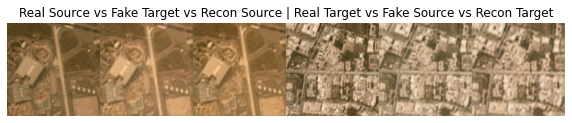

Epoch 1/15 finished at 16:12:36.434990
                [G Loss: 0.9622528553009033]	[D Loss: 0.7133962512016296]
identity loss source: 0.09299495071172714
identity loss targ: 0.08762829005718231
wganloss_S: 0.43902066349983215
wganloss_T: -0.5014321804046631
cycle loss source: 0.26319193840026855
cycle loss targ: 0.19689562916755676

identity loss source: 0.1374354362487793
identity loss targ: 0.11038149893283844
wganloss_S: 0.43941548466682434
wganloss_T: -0.5188534259796143
cycle loss source: 0.27278390526771545
cycle loss targ: 0.35967811942100525

identity loss source: 0.15994799137115479
identity loss targ: 0.11995092779397964
wganloss_S: 0.42563396692276
wganloss_T: -0.5318398475646973
cycle loss source: 0.4106200337409973
cycle loss targ: 0.4124200940132141

identity loss source: 0.09961365163326263
identity loss targ: 0.07285330444574356
wganloss_S: 0.4325365722179413
wganloss_T: -0.5347294211387634
cycle loss source: 0.1706615388393402
cycle loss targ: 0.22194001078605652

ide

identity loss source: 0.10941789299249649
identity loss targ: 0.11765547841787338
wganloss_S: 0.4857485294342041
wganloss_T: -0.5560526847839355
cycle loss source: 0.30298805236816406
cycle loss targ: 0.29414719343185425

identity loss source: 0.09598532319068909
identity loss targ: 0.11140347272157669
wganloss_S: 0.4713665544986725
wganloss_T: -0.5414485931396484
cycle loss source: 0.260390967130661
cycle loss targ: 0.23108430206775665

identity loss source: 0.08836480975151062
identity loss targ: 0.11816330254077911
wganloss_S: 0.4715498387813568
wganloss_T: -0.5370007753372192
cycle loss source: 0.25959885120391846
cycle loss targ: 0.19945493340492249

identity loss source: 0.09005779027938843
identity loss targ: 0.0953158438205719
wganloss_S: 0.4573094844818115
wganloss_T: -0.4937027394771576
cycle loss source: 0.23443064093589783
cycle loss targ: 0.19253776967525482

identity loss source: 0.1153920590877533
identity loss targ: 0.058007121086120605
wganloss_S: 0.45482179522514343
w

identity loss source: 0.13034899532794952
identity loss targ: 0.10592292249202728
wganloss_S: 0.5083358287811279
wganloss_T: -0.5893399715423584
cycle loss source: 0.2236384004354477
cycle loss targ: 0.2748981714248657

identity loss source: 0.10500381886959076
identity loss targ: 0.07605207711458206
wganloss_S: 0.5204137563705444
wganloss_T: -0.5776124000549316
cycle loss source: 0.16661864519119263
cycle loss targ: 0.22487014532089233

identity loss source: 0.0858742743730545
identity loss targ: 0.07405699789524078
wganloss_S: 0.5197902321815491
wganloss_T: -0.5850661396980286
cycle loss source: 0.16535305976867676
cycle loss targ: 0.1998603492975235

identity loss source: 0.12594081461429596
identity loss targ: 0.08912408351898193
wganloss_S: 0.5425606966018677
wganloss_T: -0.597461462020874
cycle loss source: 0.19699227809906006
cycle loss targ: 0.2719421982765198

identity loss source: 0.09329332411289215
identity loss targ: 0.07173347473144531
wganloss_S: 0.540867269039154
wganlo

identity loss source: 0.13858839869499207
identity loss targ: 0.08021899312734604
wganloss_S: 0.5334790945053101
wganloss_T: -0.5322189927101135
cycle loss source: 0.17308054864406586
cycle loss targ: 0.28946828842163086

identity loss source: 0.11863850057125092
identity loss targ: 0.07184791564941406
wganloss_S: 0.5499421954154968
wganloss_T: -0.5313137769699097
cycle loss source: 0.15060991048812866
cycle loss targ: 0.24797126650810242

identity loss source: 0.12582191824913025
identity loss targ: 0.10000009834766388
wganloss_S: 0.55242919921875
wganloss_T: -0.5276302695274353
cycle loss source: 0.22239375114440918
cycle loss targ: 0.2700381875038147

identity loss source: 0.09667045623064041
identity loss targ: 0.10441762208938599
wganloss_S: 0.5297679901123047
wganloss_T: -0.5261825323104858
cycle loss source: 0.22577807307243347
cycle loss targ: 0.2019856721162796

identity loss source: 0.12659254670143127
identity loss targ: 0.09733691066503525
wganloss_S: 0.5330396294593811
wga

identity loss source: 0.08380062133073807
identity loss targ: 0.07339781522750854
wganloss_S: 0.5666378736495972
wganloss_T: -0.538116991519928
cycle loss source: 0.17134921252727509
cycle loss targ: 0.185743510723114

identity loss source: 0.09051420539617538
identity loss targ: 0.10027353465557098
wganloss_S: 0.5707855224609375
wganloss_T: -0.5430665612220764
cycle loss source: 0.23289889097213745
cycle loss targ: 0.2154729962348938

identity loss source: 0.09298137575387955
identity loss targ: 0.10390796512365341
wganloss_S: 0.5585089325904846
wganloss_T: -0.5352017283439636
cycle loss source: 0.23466481268405914
cycle loss targ: 0.21437335014343262

identity loss source: 0.12228547036647797
identity loss targ: 0.07048682123422623
wganloss_S: 0.5611955523490906
wganloss_T: -0.528420090675354
cycle loss source: 0.17898520827293396
cycle loss targ: 0.2661890983581543

identity loss source: 0.09199947863817215
identity loss targ: 0.12143154442310333
wganloss_S: 0.5547475218772888
wganl

identity loss source: 0.10699884593486786
identity loss targ: 0.07079635560512543
wganloss_S: 0.530643880367279
wganloss_T: -0.5110008120536804
cycle loss source: 0.15485858917236328
cycle loss targ: 0.23467573523521423

identity loss source: 0.11070090532302856
identity loss targ: 0.07728458940982819
wganloss_S: 0.5241269469261169
wganloss_T: -0.5291570425033569
cycle loss source: 0.20288953185081482
cycle loss targ: 0.23928943276405334

identity loss source: 0.12047272175550461
identity loss targ: 0.08716283738613129
wganloss_S: 0.5487814545631409
wganloss_T: -0.5274562835693359
cycle loss source: 0.21098825335502625
cycle loss targ: 0.2736808955669403

identity loss source: 0.1075214073061943
identity loss targ: 0.08431126177310944
wganloss_S: 0.523934543132782
wganloss_T: -0.5335487723350525
cycle loss source: 0.19047540426254272
cycle loss targ: 0.24587544798851013

identity loss source: 0.10100561380386353
identity loss targ: 0.10079798102378845
wganloss_S: 0.5642403364181519
wga

identity loss source: 0.09607112407684326
identity loss targ: 0.08120036125183105
wganloss_S: 0.5007774233818054
wganloss_T: -0.504362940788269
cycle loss source: 0.18442101776599884
cycle loss targ: 0.210312619805336

identity loss source: 0.08453439176082611
identity loss targ: 0.06504305452108383
wganloss_S: 0.5082570910453796
wganloss_T: -0.4993510842323303
cycle loss source: 0.1465386152267456
cycle loss targ: 0.19177955389022827

identity loss source: 0.10036072134971619
identity loss targ: 0.09561236947774887
wganloss_S: 0.5332701802253723
wganloss_T: -0.4923307001590729
cycle loss source: 0.22505557537078857
cycle loss targ: 0.2330927699804306

identity loss source: 0.09743080288171768
identity loss targ: 0.09036320447921753
wganloss_S: 0.5118488669395447
wganloss_T: -0.46913617849349976
cycle loss source: 0.22663378715515137
cycle loss targ: 0.23935453593730927

identity loss source: 0.08236221969127655
identity loss targ: 0.11297822743654251
wganloss_S: 0.5316064953804016
wga

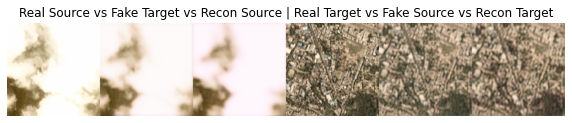

Epoch 1/15 finished at 16:15:13.377555
                [G Loss: 0.7141671180725098]	[D Loss: 0.9940632581710815]
identity loss source: 0.08199752122163773
identity loss targ: 0.1062193214893341
wganloss_S: 0.41033709049224854
wganloss_T: -0.5242527723312378
cycle loss source: 0.22911062836647034
cycle loss targ: 0.17265720665454865

identity loss source: 0.0877567008137703
identity loss targ: 0.09739646315574646
wganloss_S: 0.5007401704788208
wganloss_T: -0.51380854845047
cycle loss source: 0.20885208249092102
cycle loss targ: 0.18507026135921478

identity loss source: 0.11196664720773697
identity loss targ: 0.15272146463394165
wganloss_S: 0.48283591866493225
wganloss_T: -0.5276891589164734
cycle loss source: 0.3309856057167053
cycle loss targ: 0.23647630214691162

identity loss source: 0.08768695592880249
identity loss targ: 0.08514631539583206
wganloss_S: 0.491131991147995
wganloss_T: -0.5193844437599182
cycle loss source: 0.18123894929885864
cycle loss targ: 0.18428222835063934

ide

identity loss source: 0.11160839349031448
identity loss targ: 0.07006804645061493
wganloss_S: 0.5138463973999023
wganloss_T: -0.5680066347122192
cycle loss source: 0.1617640107870102
cycle loss targ: 0.2355223149061203

identity loss source: 0.12257330864667892
identity loss targ: 0.08202767372131348
wganloss_S: 0.5061731338500977
wganloss_T: -0.5634382963180542
cycle loss source: 0.19179649651050568
cycle loss targ: 0.2735012471675873

identity loss source: 0.12149430066347122
identity loss targ: 0.060965754091739655
wganloss_S: 0.5066114068031311
wganloss_T: -0.5484261512756348
cycle loss source: 0.1797601729631424
cycle loss targ: 0.2641763687133789

identity loss source: 0.07247009873390198
identity loss targ: 0.11011458933353424
wganloss_S: 0.47463616728782654
wganloss_T: -0.562019944190979
cycle loss source: 0.24114257097244263
cycle loss targ: 0.16194021701812744

identity loss source: 0.09163912385702133
identity loss targ: 0.0664399191737175
wganloss_S: 0.46264684200286865
wga

identity loss source: 0.09663891792297363
identity loss targ: 0.11410395801067352
wganloss_S: 0.4952622056007385
wganloss_T: -0.528548002243042
cycle loss source: 0.25689032673835754
cycle loss targ: 0.22040008008480072

identity loss source: 0.08704069256782532
identity loss targ: 0.05202379450201988
wganloss_S: 0.5223779678344727
wganloss_T: -0.5235719084739685
cycle loss source: 0.1116073802113533
cycle loss targ: 0.1884222775697708

identity loss source: 0.14851710200309753
identity loss targ: 0.07805706560611725
wganloss_S: 0.5249985456466675
wganloss_T: -0.5388993620872498
cycle loss source: 0.1762530356645584
cycle loss targ: 0.3199189603328705

identity loss source: 0.09220355749130249
identity loss targ: 0.07624952495098114
wganloss_S: 0.5283205509185791
wganloss_T: -0.5179665684700012
cycle loss source: 0.17032219469547272
cycle loss targ: 0.21017687022686005

identity loss source: 0.12306123226881027
identity loss targ: 0.06635221838951111
wganloss_S: 0.5476498007774353
wgan

KeyboardInterrupt: 

In [11]:
history = {'epoch':[],'G_loss': [], 'DS_loss':[], 'DT_loss':[], 'batch':[]}

model = Pixel_Level_Augmented_CycleGAN(gan_mode='wgangp')
best_gen_loss = 1e6
best_DT_loss = 1e6
best_DS_loss = 1e6

n_epochs = 15

for e in range(n_epochs):
    for i, batch in tqdm(enumerate(train_dataloader)):
        model.data_input(batch)
        G_loss, DS_loss, DT_loss, DS, DT, GST, GTS = model.optimize()
        
        if DS_loss < best_DS_loss:
            best_DS_loss = DS_loss
            torch.save({ 'D_S': DS.state_dict()}, 'best_DS.pt')
 
        if DT_loss < best_DT_loss:
            best_DT_loss = DT_loss
            torch.save({'D_T': DT.state_dict()}, 'best_DT.pt')
            
        if G_loss < best_gen_loss:
            best_gen_loss = G_loss
            torch.save({ 'G_ST': GST.state_dict(),'G_TS': GTS.state_dict()}, 'best_gens.pt')
            
        
        if (i+1) % 250 == 0:
            with torch.no_grad():
                now = datetime.datetime.now()
                model.sample_images(val_dataloader, e, i, save=True)
                print(f"Epoch {e + 1}/{n_epochs} finished at {now.time()}\n\
                [G Loss: {G_loss.item()}]\t[D Loss: {DS_loss.item()+ DT_loss.item()}]")
   
            history['G_loss'].append(G_loss.item())
            history['DS_loss'].append(DS_loss.item())
            history['DT_loss'].append(DT_loss.item())
            history['batch'].append(i+1)
            history['epoch'].append(e+1)

In [9]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)

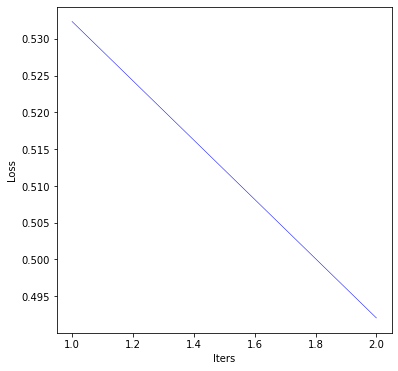

In [11]:
trainloss(df['G_loss'], df['epoch'], save = True, fig_name='G_loss')

In [12]:
df

,epoch,G_loss,DS_loss,DT_loss,batch
0,1,0.532375,-0.000495,-0.004222,5036
1,2,0.492039,-0.023363,-0.036437,5036
